# ResNet

## 1) Dataset consideration

Given a determined task and a dataset, the first thing to do is to study the dataset to determine an approach for dealing with the problem and the model creation.

Possible questions to answer:
1. What is the task to accomplish? (e.g. Classification, Detection, Segmentation, etc.)
2. Is the dataset useful (or enough) to complete succesfully the given tasks?
3. Which are the main characterisitcs of the dataset? (e.g. number of images, size, channels, are they focused on a subject or not, etc.)
4. Are there any transforamtion to apply to the dataset before input them into the model?


### 1.1) Example of Dataset Examination: BRAIN-TUMOR-MRI-DATASET

1. Classify the different type of tumors
2. It may needs more data (Brain-MRI-Images-for-Brain-Tumor-Detection could be a great assist)
3. The images have different size, they have differenc margine and the orientation of the subject is not the same in every image. Moreover, the images are represented in grayscale.
4. Normalization of the image, resize, horizontal and vertical flip are possible transformation to consider.

> Note: The dataset may not be enough to train a model to classify the different type of tumors. Experiments are required.


# CODE

---
## 1) Custom Dataset

A good example is found [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [1]:
from __future__ import print_function, division
import os
from pathlib import Path
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from torchvision.io import read_image
from torchvision.transforms import v2
import cv2

# For creating the model
import torch.nn as nn
import torch.nn.functional as F

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
# Set up GPU 
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# If you want a tensor to be on GPU you can call .cuda().
X_train = torch.FloatTensor([0., 1., 2.])
# X_train = X_train.cuda() 
# To get the index of the currently selected device. 
print(torch.cuda.current_device()) # returns 0 in my case
# To get the number of GPUs available.
print(torch.cuda.device_count()) # returns 1 in my case
# To get the name of the device.
print(torch.cuda.get_device_name(0))

# PyTorch provides a simple to use API to transfer the tensor generated on CPU to GPU. Luckily the new tensors are generated on the same device as the parent tensor.
# X_train = X_train.to(device)
# X_train.is_cuda
# The same logic applies to the model. 
# model = MyModel(args)
# model.to(device)

# Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

# net.to(device)

# Remember that you will have to send the inputs and targets at every step to the GPU too:

# inputs, labels = data[0].to(device), data[1].to(device)







True
cuda:0
0
1
NVIDIA GeForce RTX 3060


In [3]:
# Possible input with the "/" at the end of the path
input_path_dataset_training = "../datasets/BRAIN-TUMOR-MRI-DATASET/brain_tumor_dataset/brain_tumor_classification/Training/"
input_path_dataset_testing = "../datasets/BRAIN-TUMOR-MRI-DATASET/brain_tumor_dataset/brain_tumor_classification/Testing/"
# retrieve the normpath (i.e. the path without the "/" at the end)
path_dataset_training = os.path.normpath(input_path_dataset_training)
path_dataset_testing = os.path.normpath(input_path_dataset_testing)
# retrieve the name of the finale direcotries that conatin the image. Later they become the name of the lables
print(os.path.basename(path_dataset_testing))
# prepare the data freame
# Explaination: the Dataset is said to be efficent if the file are retrieve inside the __getitem__ function and not in the __init__ function.
#               Thus, the DataFrame will store only the path and also it lets me extract easly the length of the dataset for the function __len__.
df = pd.DataFrame(columns=["path","label"])
# # Useful visualization of the function os.walk()
# for path, subdirs, files in os.walk(path_dataset_testing):
#     print("################################################")
#     print(path)
#     print(subdirs)
#     print(files)

for path, subdirs, files in os.walk(input_path_dataset_training):
    for name in files:
        new_row = {"path": os.path.join(path, name), "label": os.path.basename(path)}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
        # print("path",path)
        # print("subdirs",subdirs)
        # print(os.path.join(path, name))


print("using len of the dataframe",len(df.index))
print("usiing shape, rows: {r}; cols: {c}".format(r=df.shape[0],c=df.shape[1]))
print("counting the num of non-NaN value", df[df.columns[0]].count())

print(df.iloc[2869, df.columns.get_loc('path')])

# new_row = {"path": os.path.join(path, name)}
# new_row = {"a": 10, "b": 10}
# df2 = df.append(new_row, ignore_index=True)


Testing
using len of the dataframe 2870
usiing shape, rows: 2870; cols: 2
counting the num of non-NaN value 2870
../datasets/BRAIN-TUMOR-MRI-DATASET/brain_tumor_dataset/brain_tumor_classification/Training/glioma_tumor/gg (390).jpg


In [4]:
classes = {"no_tumor" : 0, "meningioma_tumor" : 1,  "glioma_tumor" : 2, "pituitary_tumor" : 3}
classes_inv = {0 : "no_tumor" , 1 : "meningioma_tumor", 2 :  "glioma_tumor", 3 : "pituitary_tumor"}

class CustomDataset(Dataset):
    """
        Custom MRI dataset.
        It inherits the abstract torch.utils.data.Dataset class and implements the two methods: __len__ and __getitem__
    """

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.root_dir = root_dir
        self.transform = transform
        self.dataset_df = self.__create_dataset_dataframe(path_dataset=self.root_dir)

    def __create_dataset_dataframe(self, path_dataset):
        # retrieve the normpath (i.e. the path without the "/" at the end)
        norm_path_dataset = os.path.normpath(path_dataset)
        df = pd.DataFrame(columns=["path","label"])
        
        for path, subdirs, files in os.walk(norm_path_dataset):
            for name in files:
                new_row = {"path": os.path.join(path, name), "label": os.path.basename(path)}
                df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
        return df

    def __len__(self):
        return len(self.dataset_df.index)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.dataset_df.iloc[idx, self.dataset_df.columns.get_loc("path")]
        # image = io.imread(img_name)
        # image = read_image(img_name)
        image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        tmp_1 = self.dataset_df.iloc[idx, self.dataset_df.columns.get_loc("label")]
        # print(tmp_1)
        labels = classes[tmp_1]
        if self.transform:
            sample = {"image": self.transform(image), "label" : labels}
        else:
            sample = {"image": image, "label": labels}

        return sample["image"], sample["label"]

2870


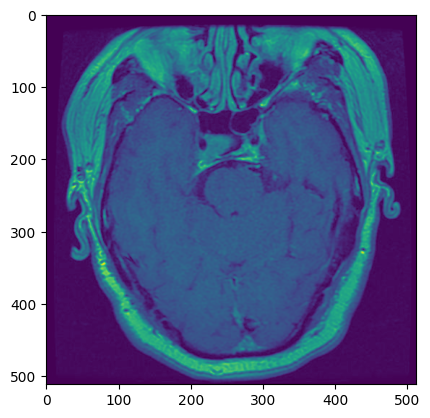

In [5]:
# TEST DATASET
MRI_dataset_training = CustomDataset(root_dir=input_path_dataset_training)
print(len(MRI_dataset_training))

plt.figure()
sample_image, sample_label = MRI_dataset_training[0]
# print(sample)
plt.imshow(sample_image)
plt.show()

# print(sample_image.shape)

### Create the Custom transformations

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'label': label}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': label}



In [6]:
# CREATION TRANSFORMATION

transforms_fn = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    v2.Resize(256), # The dimension of the imag§e I want
    
    v2.RandomAffine(degrees=(0, 180), scale=(0.95, 1.05)), # The this function should help the network to identify the tumors of various size and orientation
    v2.RandomCrop(size=(224, 224)), # the crop size is quite similar to the resize, with this I try to force the receptive fields to learn the feature almost everywhere
    
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.456], std=[0.224]),
])


Image([[[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        ...,
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]]], ) 3


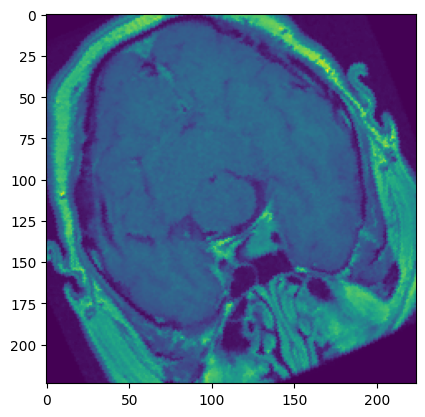

True

In [7]:
# TEST DATASET 
MRI_dataset_training = CustomDataset(root_dir=input_path_dataset_training,
                                     transform=transforms_fn)
plt.figure()
# for i in range(len(MRI_dataset_training)):
sample_image,  sample_label = MRI_dataset_training[0]
print(sample_image, sample_label)
plt.imshow(sample_image.reshape((224,224)))
plt.show()

def linear_normalization(image, new_max, new_min):
    min_val = image.min()
    max_val = image.max()
    new_min = 0
    new_max = 255
    
    return (((image - min_val) * (new_max - new_min))/(max_val - min_val)) + new_min

image_lin = linear_normalization(image=sample_image.numpy().transpose(), new_max=255, new_min=0)
# print(image_lin)
cv2.imwrite("img.png",image_lin)



#### Possible function to quickly proccess the dataset

> TODO: the ```CustomDataset``` provides the posisbility to read the DataFrame of the dataset. This can enhance the possibility to create function to quickly load a pre-existen DataFrame to quickly access a datase. Moreover, gives fast access to some statistics like the number of image for labels, which could provides important insight of the dataset structure.

In [8]:
MRI_dataset_training.dataset_df.describe()

print(MRI_dataset_training.dataset_df.groupby(["label"]).count())

                  path
label                 
glioma_tumor       826
meningioma_tumor   822
no_tumor           395
pituitary_tumor    827


### Create the Dataloader

The Pytorch ```torch.utils.data.DataLoader``` provides three important features for using easly a dataset for training a network:

- Batching the data
- Shuffling the data
- Load the data in parallel using ```multiprocessing``` workers.


In [9]:
# TEST DATALOADER
dataloader = DataLoader(MRI_dataset_training, batch_size=4,
                        shuffle=True, num_workers=4)



for i_batch, sample_batched in enumerate(dataloader):
    images, labels = sample_batched
    print(i_batch, images.size(), labels)

# BOTH IMAGES AND LABELS MUST BE TENSORS!!!


0 torch.Size([4, 1, 224, 224]) tensor([3, 3, 1, 0])
1 torch.Size([4, 1, 224, 224]) tensor([0, 2, 2, 1])
2 torch.Size([4, 1, 224, 224]) tensor([1, 1, 2, 2])
3 torch.Size([4, 1, 224, 224]) tensor([0, 2, 1, 2])
4 torch.Size([4, 1, 224, 224]) tensor([1, 3, 3, 1])
5 torch.Size([4, 1, 224, 224]) tensor([3, 3, 2, 3])
6 torch.Size([4, 1, 224, 224]) tensor([1, 1, 1, 2])
7 torch.Size([4, 1, 224, 224]) tensor([3, 1, 2, 2])
8 torch.Size([4, 1, 224, 224]) tensor([2, 3, 1, 1])
9 torch.Size([4, 1, 224, 224]) tensor([0, 2, 3, 3])
10 torch.Size([4, 1, 224, 224]) tensor([1, 2, 3, 3])
11 torch.Size([4, 1, 224, 224]) tensor([0, 2, 1, 2])
12 torch.Size([4, 1, 224, 224]) tensor([2, 2, 2, 2])
13 torch.Size([4, 1, 224, 224]) tensor([0, 2, 2, 1])
14 torch.Size([4, 1, 224, 224]) tensor([2, 3, 3, 0])
15 torch.Size([4, 1, 224, 224]) tensor([1, 2, 3, 0])
16 torch.Size([4, 1, 224, 224]) tensor([2, 1, 1, 1])
17 torch.Size([4, 1, 224, 224]) tensor([1, 1, 3, 3])
18 torch.Size([4, 1, 224, 224]) tensor([3, 2, 3, 3])
19 

Training set has 2870 instances
Validation set has 394 instances
Feature batch shape: torch.Size([32, 1, 224, 224])
Labels batch shape: torch.Size([32])


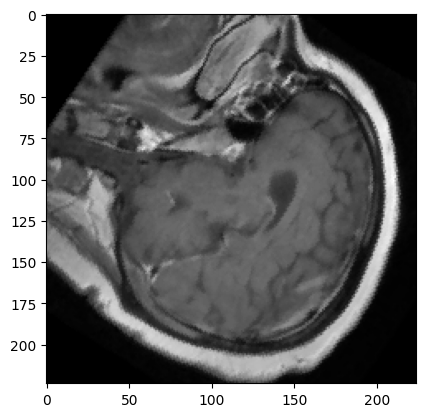

<class 'torch.Tensor'>
torch.Size([])
tensor(3)
3
Label: pituitary_tumor


In [10]:
batch_size = 32

# Create datasets for training & validation, download if necessary
training_set = CustomDataset(root_dir=input_path_dataset_training,transform=transforms_fn)
validation_set = CustomDataset(root_dir=input_path_dataset_testing, transform=transforms_fn)

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)

# # Class labels
# classes = ("glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor")

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))


# Display image and label.
train_features, train_labels = next(iter(train_loader))

# print(type(train_features))
# print(type(train_labels))
# print(next(iter(train_loader)))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}") 

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(type(label))
print(label.size())
print(label)
print(label.item())
print("Label: {}".format(classes_inv[label.item()]))

### Create the ResNet Model (ResNet-34 like in the papaer)

There is a really good implementation of the ResNet34 [here(Kaggle)](https://www.kaggle.com/code/poonaml/building-resnet34-from-scratch-using-pytorch) and [here](https://www.digitalocean.com/community/tutorials/writing-resnet-from-scratch-in-pytorch)

The thing which is the "_most difficult_" to udnerstand about the structrue of the ResNet model is the shortcut and how it is calculated

e.g. block_out = (N, 128, 27, 27) residual = (N, 64, 53, 53)

In [ ]:
RESNET-34 MY FUNCTION 
class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34, self).__init__()
        param7x7 = [1, 64, 7, 2, 3]
        self.conv7x7 = nn.Conv2d(in_channels=param7x7[0], out_channels=param7x7[1], kernel_size=param7x7[2], 
                                 stride=param7x7[3], padding=param7x7[4])
        self.bn = nn.BatchNorm2d(num_features=param7x7[1])
        self.maxpool = nn.MaxPool2d(kernel_size=param7x7[2], stride=2)
        

        self.paramB1 = [64, 64, 3, 1, 1]
        self.paramB2 = [64, 64, 3, 1, 1]
        self.paramB3 = [64, 64, 3, 1, 1]
        self.paramB4 = [64, 128, 3, 2, 1]
        self.paramB5 = [128, 128, 3, 1, 1]
        self.paramB6 = [128, 128, 3, 1, 1]
        self.paramB7 = [128, 128, 3, 1, 1]
        self.paramB8 = [128, 256, 3, 2, 1]
        self.paramB9 = [256, 256, 3, 1, 1]
        self.paramB10 = [256, 256, 3, 1, 1]
        self.paramB11 = [256, 256, 3, 1, 1]
        self.paramB12 = [256, 256, 3, 1, 1]
        self.paramB13 = [256, 256, 3, 1, 1]
        self.paramB14 = [256, 512, 3, 2, 1]
        self.paramB15 = [512, 512, 3, 1, 1]
        self.paramB16 = [512, 512, 3, 1, 1]
    
        self.avgpool = nn.AvgPool2d(kernel_size=7)
        self.fc1 = nn.Linear(in_features=512, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=4)
        
    
    def __resBlock(self, x, in_channels, out_channels, kernel_size, first_stride=1):
        residual = x
        x = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=first_stride, padding=1)(x)
        x = nn.BatchNorm2d(num_features=out_channels)(x)
        x = F.relu(x)
        x = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1)(x)
        x = nn.BatchNorm2d(num_features=out_channels)(x)
        print("Curr Val: {curr} - Residual {res}".format(curr=x.size(), res=residual.size()))
        if x.size() != residual.size():
            # pad residual
            # t4d = torch.empty(3, 3, 4, 2)
            p_res = (32, 32, 0, 0, 0, 0) # pad by (0, 1), (2, 1), and (3, 3)
            residual = F.pad(residual, p_res, "constant", 0)

            p_x = (13, 13, 13, 13)
            x = F.pad(x, p_x, "constant", 0)
            
        x = x + residual
        x = F.relu(x)
        return x
    
    def forward(self, x):
        x = self.conv7x7(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.__resBlock(x, in_channels=self.paramB1[0], out_channels=self.paramB1[1], kernel_size=self.paramB1[2], first_stride=self.paramB1[3])
        x = self.__resBlock(x, in_channels=self.paramB2[0], out_channels=self.paramB2[1], kernel_size=self.paramB2[2], first_stride=self.paramB2[3])
        x = self.__resBlock(x, in_channels=self.paramB3[0], out_channels=self.paramB3[1], kernel_size=self.paramB3[2], first_stride=self.paramB3[3])
        x = self.__resBlock(x, in_channels=self.paramB4[0], out_channels=self.paramB4[1], kernel_size=self.paramB4[2], first_stride=self.paramB4[3])
        x = self.__resBlock(x, in_channels=self.paramB5[0], out_channels=self.paramB5[1], kernel_size=self.paramB5[2], first_stride=self.paramB5[3])
        x = self.__resBlock(x, in_channels=self.paramB6[0], out_channels=self.paramB6[1], kernel_size=self.paramB6[2], first_stride=self.paramB6[3])
        x = self.__resBlock(x, in_channels=self.paramB7[0], out_channels=self.paramB7[1], kernel_size=self.paramB7[2], first_stride=self.paramB7[3])
        x = self.__resBlock(x, in_channels=self.paramB8[0], out_channels=self.paramB8[1], kernel_size=self.paramB8[2], first_stride=self.paramB8[3])
        x = self.__resBlock(x, in_channels=self.paramB9[0], out_channels=self.paramB9[1], kernel_size=self.paramB9[2], first_stride=self.paramB9[3])
        x = self.__resBlock(x, in_channels=self.paramB10[0], out_channels=self.paramB10[1], kernel_size=self.paramB10[2], first_stride=self.paramB10[3])
        x = self.__resBlock(x, in_channels=self.paramB11[0], out_channels=self.paramB11[1], kernel_size=self.paramB11[2], first_stride=self.paramB11[3])
        x = self.__resBlock(x, in_channels=self.paramB12[0], out_channels=self.paramB12[1], kernel_size=self.paramB12[2], first_stride=self.paramB12[3])
        x = self.__resBlock(x, in_channels=self.paramB13[0], out_channels=self.paramB13[1], kernel_size=self.paramB13[2], first_stride=self.paramB13[3])
        x = self.__resBlock(x, in_channels=self.paramB14[0], out_channels=self.paramB14[1], kernel_size=self.paramB14[2], first_stride=self.paramB14[3])
        x = self.__resBlock(x, in_channels=self.paramB15[0], out_channels=self.paramB15[1], kernel_size=self.paramB15[2], first_stride=self.paramB15[3])
        x = self.__resBlock(x, in_channels=self.paramB16[0], out_channels=self.paramB16[1], kernel_size=self.paramB16[2], first_stride=self.paramB16[3])
        
        x = self.avgpool(x)
        x = x.view(self.paramB16[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
        
                         
        # Block 1
model_ResNet34 = ResNet34()
        

### Error Residual 

The output of the previous cell, is the following

```
Type of inputs:  <class 'torch.Tensor'>
Type of lables:  <class 'torch.Tensor'>
Curr Val: torch.Size([32, 64, 53, 53]) - Residual torch.Size([32, 64, 53, 53])
Curr Val: torch.Size([32, 64, 53, 53]) - Residual torch.Size([32, 64, 53, 53])
Curr Val: torch.Size([32, 64, 53, 53]) - Residual torch.Size([32, 64, 53, 53])
Curr Val: torch.Size([32, 128, 27, 27]) - Residual torch.Size([32, 64, 53, 53])

...

RuntimeError: The size of tensor a (53) must match the size of tensor b (117) at non-singleton dimension 3

```

And it represents the exact point in which the model is trying to calculate del sum between the conv output and the residual.

In case the channels dimensions and the feature maps size change, the sum cannot be applied (due to different size)

In my case I have these dimensions: ```([32, 128, 27, 27]) - Residual torch.Size([32, 64, 53, 53])```,  that means that during the convolution, the size the image was halved and the number of channels id doubled.

To solve this problem in the paper suggest to use padding zeros to avoid adding parameters to train or to use a mapping (not an identity mapping as the previous one) that make use of a conv2d with kernel size 1x1 and stride 2.
This will increase the number of channels and reduce the size of the Width and height.

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet34(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet34, self).__init__()
        self.inplanes = 64
        self.inChannels = 1
        self.conv1 = nn.Sequential(
                        nn.Conv2d(self.inChannels, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
        
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x
                         

In [12]:
# TEST MODEL & DataLoader
    
num_classes = 10
num_epochs = 20
batch_size = 16
learning_rate = 0.01

model_ResNet34 = ResNet34(ResidualBlock, [3, 4, 6, 3])
# model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

for i, data in enumerate(train_loader):
    # Every data instance is an input + label pair
    # inputs, labels = data["image"], data["label"]
    # # BETTER VERSION:
    inputs, labels = data
    # # Where data tuple of element --> the CustomDataset last line should be "return image, label"
    print("Type of inputs: ",type(inputs), inputs.size())
    print("Type of lables: ",type(labels))
    
    # Zero your gradients for every batch!
    # optimizer.zero_grad()
    
    # Make predictions for this batch
    outputs = model_ResNet34(inputs)
    print("Output type: ", type(outputs))
    print("Output size: ", outputs.size())
    print("Output     : ", outputs)
    break


model_ResNet34.to(device)





Type of inputs:  <class 'torch.Tensor'> torch.Size([32, 1, 224, 224])
Type of lables:  <class 'torch.Tensor'>
Output type:  <class 'torch.Tensor'>
Output size:  torch.Size([32, 10])
Output     :  tensor([[-4.8188e-01,  2.2260e-01, -7.0688e-02, -1.8701e-01,  6.2276e-01,
          1.1005e-01, -7.5133e-01, -8.0276e-01, -9.4208e-01,  6.3748e-01],
        [-3.5151e-01,  4.5532e-01,  1.0635e-02,  1.6923e-01,  1.5227e-01,
          1.4627e-02, -5.3739e-01, -7.1947e-01, -2.0734e-01,  3.6860e-01],
        [-3.0553e-01,  3.1440e-01,  2.7062e-01, -1.4848e-01,  3.9197e-01,
          1.7261e-01, -9.2975e-01, -7.3909e-01, -9.3382e-01,  5.2906e-01],
        [-4.0211e-01,  7.2675e-01,  5.5079e-01,  4.7674e-03,  2.0121e+00,
          1.1700e-01, -1.5732e+00, -7.7771e-01, -1.7129e+00,  1.6188e+00],
        [-3.2354e-01,  3.0384e-01,  1.0342e-01,  3.9563e-02,  2.5163e-01,
          1.5168e-01, -8.1235e-01, -6.3251e-01, -7.7011e-01,  5.9755e-01],
        [-1.8596e-01,  3.4989e-01,  1.9428e-01,  1.0863e-01

ResNet34(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

### Create the loss function

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[7.6390e-01, 1.6603e-02, 1.7156e-01, 7.1283e-01, 2.5424e-01, 3.0394e-01,
         2.7739e-01, 4.6031e-01, 9.4255e-02, 7.0058e-01],
        [5.4312e-01, 8.7983e-02, 5.0528e-01, 8.3144e-01, 4.6955e-01, 5.1495e-01,
         6.8244e-01, 7.9701e-01, 5.1728e-01, 2.7198e-01],
        [3.0755e-01, 4.4240e-01, 7.6348e-04, 5.5049e-02, 6.0713e-02, 3.6176e-01,
         1.9067e-01, 5.9814e-01, 5.3316e-01, 1.4320e-01],
        [9.0341e-01, 7.6139e-01, 6.2634e-01, 9.5049e-01, 9.8882e-01, 5.7625e-02,
         7.6133e-01, 1.6744e-01, 9.7961e-01, 3.7796e-01]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.6012377738952637


### Create the Optimizer

In [14]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model_ResNet34.parameters(), lr=0.001, momentum=0.9)

## Create the Training Loop function
---

The every Training Loop has 5 steps that are share among each tasks of deep learning:
1. Inference
2. Calculate the Loss
3. Zeros the gradient (e.g. for CNN but not for RNN)
4. Optimize
5. Step

On pytorch documentation, there is  a beautiful function that those the following:

- Gets a batch of training data from the DataLoader

- Zeros the optimizer’s gradients

- Performs an inference - that is, gets predictions from the model for an input batch

- Calculates the loss for that set of predictions vs. the labels on the dataset

- Calculates the backward gradients over the learning weights

- Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose

- It reports on the loss for every 1000 batches.

- Finally, it reports the average per-batch loss for the last 1000 batches, for comparison with a validation run


In [15]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(train_loader) instead of
    # iter(train_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)
        

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model_ResNet34(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 10 == 0:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

### Per-Epoch Activity

There are a couple of things we’ll want to do once per epoch:

- Perform validation by checking our relative loss on a set of data that was not used for training, and report this

- Save a copy of the model


In [16]:
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter("runs/fashion_trainer_{}".format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

In [17]:
for epoch in range(EPOCHS):
    print("EPOCH {}:".format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model_ResNet34.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population 
    # Statictics for batch normalization.
    model_ResNet34.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vadata in enumerate(validation_loader):
            vinputs, vlabels = vadata[0].to(device), vadata[1].to(device)
            voutputs = model_ResNet34(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss


    avg_vloss = running_vloss / (i + 1)
    print("Loss train {} valid {}".format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch 
    # for both training and validation
    writer.add_scalars("Training vs. Validation Loss",
                      { "Training" : avg_loss, "Validation" : avg_vloss},
                      epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = "model_{}_{}".format(timestamp, epoch_number)
        torch.save(model_ResNet34.state_dict(), model_path)
    epoch_number += 1

EPOCH 1:
  batch 1 loss: 0.002208838939666748
  batch 11 loss: 0.01569657063484192
  batch 21 loss: 0.011771645188331605
  batch 31 loss: 0.010667667031288146
  batch 41 loss: 0.009969954013824462
  batch 51 loss: 0.010085848927497863
  batch 61 loss: 0.00873771095275879
  batch 71 loss: 0.008906221389770508
  batch 81 loss: 0.00890785175561905
Loss train 0.00890785175561905 valid 1.8957111835479736
EPOCH 2:
  batch 1 loss: 0.0008566294312477112
  batch 11 loss: 0.008883773803710937
  batch 21 loss: 0.008336149275302887
  batch 31 loss: 0.008860416054725647
  batch 41 loss: 0.007116962075233459
  batch 51 loss: 0.008146690726280213
  batch 61 loss: 0.007361099660396576
  batch 71 loss: 0.007053407967090607
  batch 81 loss: 0.007145103752613067
Loss train 0.007145103752613067 valid 3.789216995239258
EPOCH 3:
  batch 1 loss: 0.0009127795696258545
  batch 11 loss: 0.006985957086086273
  batch 21 loss: 0.005581908941268921
  batch 31 loss: 0.006043547093868256
  batch 41 loss: 0.0061146305